In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

from dask_ml.preprocessing import Categorizer, OrdinalEncoder
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LinearRegression
from dask_ml.metrics import mean_absolute_error

from lightgbm.dask import DaskLGBMRegressor

import os

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 62.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41667,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43683,Total threads: 4
Dashboard: http://127.0.0.1:45975/status,Memory: 10.44 GiB
Nanny: tcp://127.0.0.1:32903,


In [3]:
path_to_csvs = "dataset/*.csv"
ddf_regions = dd.read_csv(path_to_csvs, blocksize="20MB")

In [4]:
ddf_regions.columns

Index(['index', 'Data', 'Hora', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)', 'region', 'state', 'station',
       'station_code', 'latitude', 'longitude', 'height'],
      dtype='object')

In [5]:
colunas_temperatura = [
    'TEMPERATURA DO PONTO DE ORVALHO (°C)',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'
]
target_column = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'

In [6]:
ddf_regions = ddf_regions.drop(columns=colunas_temperatura)

In [7]:
ddf_regions.dtypes

index                                                              int64
Data                                                     string[pyarrow]
Hora                                                     string[pyarrow]
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                                 float64
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)            float64
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)                  float64
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)                 float64
RADIACAO GLOBAL (Kj/m²)                                            int64
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)                     float64
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                           int64
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                           int64
UMIDADE RELATIVA DO AR, HORARIA (%)                                int64
VENTO, DIREÇÃO HORARIA (gr) (° (gr))                               int64
VENTO, RAJADA MAXIMA (m/s)                         

In [8]:
ddf_filtered = ddf_regions[ddf_regions[target_column] != -9999]

In [9]:
categorical_cols = [
    "Data",
    "Hora",
    "region",
    "state",
    "station",
    "station_code",
]

In [10]:
categorizer = Categorizer(columns=categorical_cols)
ddf_categorized = categorizer.fit_transform(ddf_filtered)

In [11]:
encoder = OrdinalEncoder()
ddf_encoded = encoder.fit_transform(ddf_categorized)

In [12]:
X = ddf_encoded.drop([target_column] + ["index"], axis=1)
y = ddf_encoded[target_column]

In [25]:
X.columns

Index(['Data', 'Hora', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)', 'region', 'state', 'station',
       'station_code', 'latitude', 'longitude', 'height'],
      dtype='object')

In [13]:
# split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [14]:
import dask.array as da

Xtr = Xtrain.to_dask_array(lengths=True)
Xts = Xtest.to_dask_array(lengths=True)
ytr = ytrain.to_dask_array(lengths=True)
yts = ytest.to_dask_array(lengths=True)

In [15]:
%%time
model = DaskLGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    objective="regression",
    random_state=42,
    verbose=2
)

model.client = client
model.fit(Xtr, ytr, eval_set=[(Xtr, ytr)], eval_metric="auc")

/opt/conda/lib/python3.10/site-packages/lightgbm/dask.py:549: UserWarning: Parameter n_jobs will be ignored.
  _log_warning(f"Parameter {param_alias} will be ignored.")


Finding random open ports for workers
[LightGBM] [Info] Trying to bind port 42451...
[LightGBM] [Info] Binding port 42451 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Info] Trying to bind port 41635...
[LightGBM] [Info] Binding port 41635 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Warning] Connecting to rank 4 failed, waiting for 200 milliseconds
[LightGBM] [Info] Trying to bind port 43233...
[LightGBM] [Info] Binding port 43233 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Warning] Connecting to rank 4 failed, waiting for 200 milliseconds
[LightGBM] [Info] Trying to bind port 42697...
[LightGBM] [Info] Binding port 42697 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Warning] Connecting to rank 4 failed, waiting for 200 milliseconds
[LightGBM] [Info] Trying to bind port 37821...
[LightGBM] [Info] Binding port 37821 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Info] Trying to bind port 35181...
[LightGBM] [Info] Binding port 35181 succeeded
[Light

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.01
,n_estimators,1000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [16]:
%%time
# Predict (returns Dask array)
y_pred = model.predict(Xts)

CPU times: user 336 ms, sys: 15.6 ms, total: 352 ms
Wall time: 442 ms


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [17]:
%%time
mean_absolute_error(yts, y_pred)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/v

CPU times: user 1min 16s, sys: 2.18 s, total: 1min 18s
Wall time: 1min 36s


np.float64(1.4540474589899497)

In [18]:
yts[:10].compute().tolist(), y_pred[:10].compute().tolist()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


([26.3, 26.9, 10.5, 25.6, 31.2, 17.5, 29.5, 20.7, 23.0, 19.5],
 [27.719490109502143,
  26.42178981922258,
  15.75381694159745,
  26.50044860102067,
  30.833986038328977,
  20.165285739292518,
  29.12029206238223,
  20.353617579516715,
  22.336066561827785,
  17.9173406465759])

In [21]:
model.feature_names_in_

array(['Column_0', 'Column_1', 'Column_2', 'Column_3', 'Column_4',
       'Column_5', 'Column_6', 'Column_7', 'Column_8', 'Column_9',
       'Column_10', 'Column_11', 'Column_12', 'Column_13', 'Column_14',
       'Column_15', 'Column_16', 'Column_17', 'Column_18', 'Column_19'],
      dtype='<U9')

In [26]:
X.columns

Index(['Data', 'Hora', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)', 'region', 'state', 'station',
       'station_code', 'latitude', 'longitude', 'height'],
      dtype='object')

In [19]:
model.feature_importances_

array([7791, 2056,  197, 1643,  626, 1115, 1002,  560,  259, 1694, 1197,
        624,  202,  425,  108,   50,  500, 4377, 1270, 4304], dtype=int32)

In [29]:
colunas = X.columns.tolist()
importancias = model.feature_importances_.tolist()

In [32]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 11.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 11.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [matplotlib]5 [matplotlib]


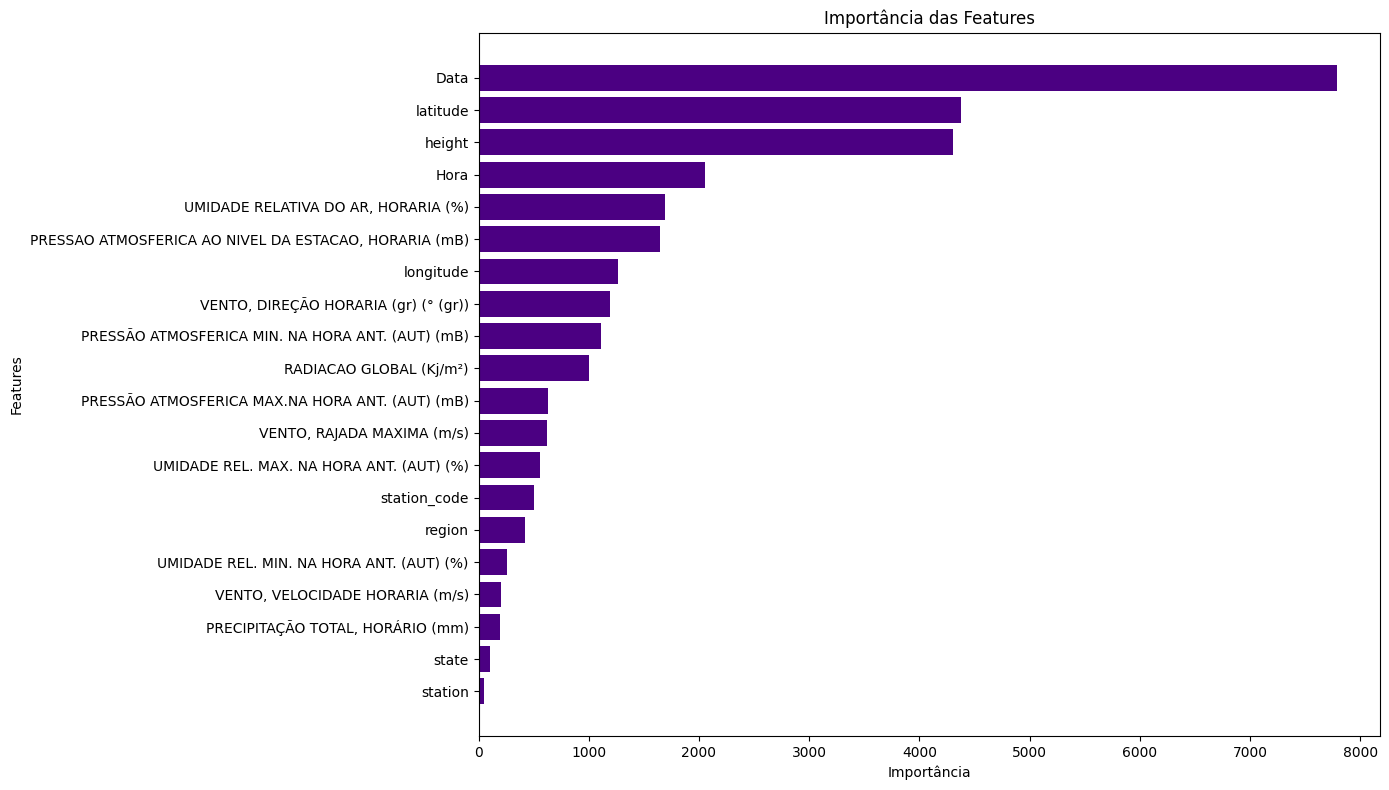

In [42]:
import matplotlib.pyplot as plt

colunas_importancia = sorted(zip(colunas, importancias), key=lambda x: x[1], reverse=True)
colunas, importancias = zip(*colunas_importancia)

plt.figure(figsize=(14, 8))
plt.barh(colunas, importancias, color='indigo')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()